In [1]:
import torch
from datasets import load_dataset

dataset_train = load_dataset("tweet_eval", "sentiment", split="train[:50]")
dataset_test = load_dataset("tweet_eval", "sentiment", split="test[:5]")
dataset_train.set_format(type="torch", columns=["text", "label"])
dataset_test.set_format(type="torch", columns=["text", "label"])

Found cached dataset tweet_eval (/home/hgoz/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Found cached dataset tweet_eval (/home/hgoz/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


In [2]:
dataset_train

Dataset({
    features: ['text', 'label'],
    num_rows: 50
})

In [3]:
from gensim.models import KeyedVectors
embeddings_kv = KeyedVectors.load_word2vec_format('./data/glove.6B.300d.w2v.txt', binary=False)

In [4]:
embeddings = torch.tensor(embeddings_kv.vectors)

In [5]:
label_to_idx = {
    'none': 0,
    'against': 1,
    'favor': 2,
}
idx_to_label = {
    0: 'none',
    1: 'against',
    2: 'favor',
}

In [6]:
x = torch.randn(3, 10, 28)
y = torch.randn(3, 28, 10)
z = torch.bmm(x, y)
z.shape


torch.Size([3, 10, 10])

In [7]:
x.permute(0, 2, 1).shape

torch.Size([3, 28, 10])

In [18]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class AttentionHead(nn.Module):
    """Scaled Dot-Product Attention"""
    
    def __init__(self, d_model, dk):
        super(AttentionHead, self).__init__()
        
        # Attention layer
        # @Note: maybe I should use the same as in the paper; where these are 
        self.w_q = nn.Linear(d_model, dk)
        self.w_k = nn.Linear(d_model, dk)
        self.w_v = nn.Linear(d_model, dk)
        self.softmax = nn.Softmax(dim=-1)
        
        # Feed Forward layer
        self.fc = nn.Linear(dk, d_model)
        
    def forward(self, X):
        batch_size, seq_len, d_model = X.shape
        
        # Apply linear transformations
        q = self.w_q(X).view(batch_size, seq_len, -1)
        k = self.w_k(X).view(batch_size, -1, seq_len)
        v = self.w_v(X)
        
        # Calculate context
        attention_scores = torch.bmm(q, k) / math.sqrt(d_model)
        attention_weights = self.softmax(attention_scores) 
        context = torch.bmm(attention_weights, v)

        output = self.softmax(self.fc(context))

        return output


class LayerNorm(nn.Module):
    
    def __init__(self, normalized_shape):
        super().__init__()
        
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))
        
    def forward(self, x):    
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + 1e-5)  + self.beta


class MyEncoder(nn.Module):
    def __init__(self, sequence_length, n_heads, num_classes):
        super(MyEncoder, self).__init__()

        d_model = embeddings.shape[1]
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True)

        # Positional Encodings
        pos_enc = torch.zeros(1, sequence_length, d_model)
        for pos in range(sequence_length):
            for i in range(0, d_model, 2):
                pos_enc[0, pos, i] = math.sin(pos / (10000 ** ((i)/d_model)))
                pos_enc[0, pos, i + 1] = math.cos(pos / (10000 ** ((i + 1)/d_model)))
        self.positional = pos_enc.to(device)
        
        # Multi-headed Attention
        dh = d_model // n_heads
        self.heads = nn.ModuleList([AttentionHead(d_model, dh) for _ in range(n_heads)])
        self.linear = nn.Linear(n_heads*d_model, d_model)
        self.ln1 = LayerNorm(d_model)
        self.drop1 = nn.Dropout(0.3)

        # Feed Forward
        self.ff1 = nn.Linear(d_model, d_model*4)
        self.ff2 = nn.Linear(d_model*4, d_model)
        self.ln2 = LayerNorm(d_model)
        self.drop2 = nn.Dropout(0.3)

        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # batch_size, seq_len, d_model = x.shape
        x = self.embedding(x)

        x += self.positional[:, :]

        # Multi-head Attention -> Add & Norm
        multi_head = self.linear(torch.cat([h(x) for h in self.heads], dim=-1))
        x = self.drop1(self.ln1(x + multi_head))

        # Feed Forward -> Add & Norm
        ffn = self.ff2(F.relu(self.ff1(x)))
        x = self.drop2(self.ln2(x + ffn))

        # Classification
        y_pred = F.log_softmax(self.fc(x), dim=1)
        return y_pred[:, -1, :]


In [9]:
# from torch.nn import TransformerEncoder, TransformerEncoderLayer

# class PositionalEncoding(nn.Module):
    
#     def __init__(self, d_model, dropout=0.1, max_len=5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)
        
#         # Compute the positional encodings once in advance
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) *
#                              -(math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.register_buffer('pe', pe)
        
#     def forward(self, x):
#         x = x + self.pe[:, :x.size(1)]        
#         return self.dropout(x)

# class TransformerModel(nn.Module):
#     def __init__(self, ntoken, d_model, nhead, d_hid, nlayers, dropout=0.5):
#         super().__init__()
#         self.d_model = d_model
#         encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
#         self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
#         self.embedding = nn.Embedding(ntoken, d_model)
#         self.pos_encoder = PositionalEncoding(d_model, dropout)
#         self.out = nn.Linear(d_model, ntoken)
    
#     def forward(self, src):
#         src = self.embedding(src) * math.sqrt(self.d_model)
#         src = self.pos_encoder(src)
#         output = self.transformer_encoder(src)
#         output = self.out(output)
#         return output

# # m = TransformerModel(embeddings.shape[0], embeddings.shape[1])

In [10]:
max_length = 0
length_counts = 0
num_texts = len(dataset_train['text'])
for text in dataset_train['text']:
    words = text.split(' ')
    length_counts += len(words)
    if len(words) > max_length:
        max_length = len(words)

print('max_length:', max_length)
print('num_texts:', num_texts)
print('total_length:', length_counts)
avg_text_length = length_counts // num_texts
print('avg text length:', avg_text_length)

max_length: 28
num_texts: 50
total_length: 957
avg text length: 19


In [11]:
train_inputs = []
for text in dataset_train['text']:
    l = []
    for w in text.split(' '):
        if w in embeddings_kv:
            l.append(embeddings_kv.key_to_index[w])
    # PAD using dots
    for i in range(max_length - len(l)):
        l.append(embeddings_kv.key_to_index['.'])
    train_inputs.append(l)
torch.tensor(train_inputs[:3]).shape

torch.Size([3, 28])

In [12]:
test_inputs = []
for text in dataset_test['text']:
    l = []
    for w in text.split(' '):
        if w in embeddings_kv:
            l.append(embeddings_kv.key_to_index[w])
    # PAD using dots
    for i in range(max_length - len(l)):
        l.append(embeddings_kv.key_to_index['.'])
    test_inputs.append(l)
torch.tensor(test_inputs[:3]).shape

torch.Size([3, 28])

In [13]:
dataset_train['label']

tensor([2, 1, 1, 1, 2, 2, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2, 2, 0, 1, 1, 2, 1, 1,
        1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 0, 2, 1, 1, 2, 2,
        1, 1])

In [ ]:
import torch_directml

# device = torch.device('cpu')
device = torch_directml.device()
train_X = torch.tensor(train_inputs).to(device)
train_y = dataset_train['label'].to(device)

In [19]:
model = MyEncoder(max_length, 4, 3).to(device)
# model.load_state_dict(torch.load('model.pt'))
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
train_losses = []
epochs = []

In [16]:
train_X.shape

torch.Size([50, 28])

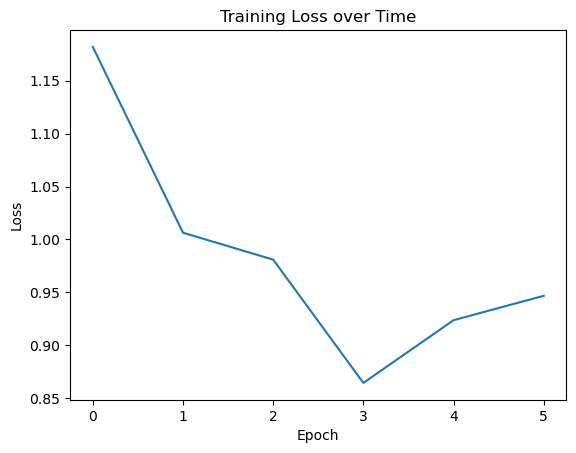

0.9466508030891418


In [21]:
num_epochs = 20

model.train()
for epoch in range(num_epochs):

    # Forward pass: compute predicted y by passing x to the model.
    output = model(train_X)

    # Calculate the loss
    loss = loss_fn(output, train_y)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()
    
    # Record loss and epoch values
    if (epoch + 1) % 5 == 0:
        train_losses.append(loss.item())
        epochs.append(epoch)
        torch.save(model.state_dict(), 'model.pt')

import matplotlib.pyplot as plt
plt.plot(torch.arange(0, len(epochs), 1), train_losses, 1)
plt.title('Training Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print(train_losses[-1])

In [22]:
test_X = torch.tensor(test_inputs).to(device)
test_y = dataset_test['label'].to(device)

model.eval()
with torch.no_grad():
    pred = model(test_X)
    pred = torch.argmax(pred, dim=1)

num_correct = (pred == test_y).sum()
accuracy = num_correct / len(test_y)

# Print the accuracy
print("The accuracy of the testing set: {:.2f}%".format(accuracy * 100))

The accuracy of the testing set: 60.00%


In [23]:
for x, y in zip(test_inputs, dataset_test['label']):
    text = ' '.join([embeddings_kv.index_to_key[i] for i in x if i != 2])
    print(idx_to_label[y.item()].upper(), ' ' * 5, text)

AGAINST       what do these naked have to do with not even like
AGAINST       had a blue penis while was with
AGAINST       but think the victims are going to be
FAVOR       think may be finally in with the in crowd
NONE       and now and are running out of
